In [13]:
%pip install -q matplotlib
%pip install -q numpy
%pip install -q torch
import matplotlib.pyplot as plt
import numpy as np
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
# !curl -O https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
# !curl -O https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
from Gridworld_model import *
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [15]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 網路參數設定

In [18]:
import numpy as np
import torch
from Gridworld_model import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape 
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

# 將原本的naive dqn加入Experience Replay Buffer

In [20]:
from collections import deque, namedtuple
import random, torch

Transition = namedtuple('T', ['s', 'a', 'r', 's1', 'done'])

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buf = deque(maxlen=capacity)

    def add(self, *args):
        """儲存一筆 (s, a, r, s')"""
        self.buf.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        t = Transition(*zip(*batch))                # 轉置
        # 轉成 tensor，方便後續計算
        return (torch.tensor(t.s,   dtype=torch.float32),
                torch.tensor(t.a,   dtype=torch.int64 ).unsqueeze(-1),
                torch.tensor(t.r,   dtype=torch.float32).unsqueeze(-1),
                torch.tensor(t.s1,  dtype=torch.float32),
                torch.tensor(t.done,dtype=torch.float32).unsqueeze(-1))

    def __len__(self):
        return len(self.buf)

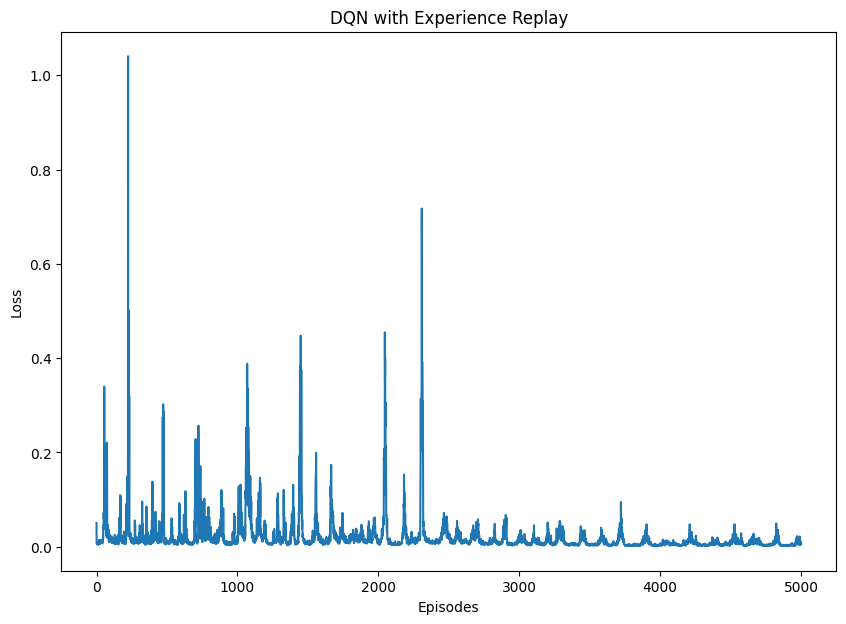

In [27]:
buffer      = ReplayBuffer(capacity=10000)
batch_size  = 64
gamma       = 0.99
epochs      = 5000
epsilon     = 1.0          # 與原程式一致
losses      = []

for i in range(epochs):
    game   = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state1 = torch.from_numpy(state_).float()
    status = 1

    while status == 1:
        # ---------- 探索 / 利用 ----------
        qval  = model(state1)
        if random.random() < epsilon:
            action_idx = np.random.randint(0,4)
        else:
            action_idx = torch.argmax(qval).item()
        action = action_set[action_idx]

        # ---------- 執行動作 ----------
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2  = torch.from_numpy(state2_).float()
        reward  = game.reward()
        done    = abs(reward) == 10           # 遊戲是否結束

        # ---------- 記錄到 Replay Buffer ----------
        state1_flat = state1.squeeze(0)      # (64,)
        state2_flat = state2.squeeze(0)

        buffer.add(state1_flat.numpy(), action_idx, reward,
           state2_flat.numpy(), done)

        # ---------- 只有 buffer 夠大時才更新 ----------
        if len(buffer) >= batch_size:
            s, a, r, s1, d = buffer.sample(batch_size)   # (B, *)
            # 計算目標值
            with torch.no_grad():
                q_next = model(s1).max(1, keepdim=True).values
                y      = r + (1 - d) * gamma * q_next     # TD target

            q_pred  = model(s).gather(1, a)               # Q(s,a)
            loss    = loss_fn(q_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        state1 = state2
        status = 0 if done else 1
    # ---------- 每回合後處理 ----------
    losses.append(loss.item())
    if epsilon > 0.1:
        epsilon -= 1/epochs

    if i % 100 == 0:
        print(f'Episode {i}, Loss {losses[-1]:.4f}')
        clear_output(wait=True)

plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('DQN with Experience Replay')
plt.show()


# 測試模型

In [16]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_) 
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break    
    win = True if status == 2 else False
    print(win)
    return win

In [26]:
test_model(model, mode='static', display=True)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True